In [2]:
import cv2
from PIL import Image
import clip
import torch
import numpy as np
import math
import pandas
import plotly.express as px
import datetime
from IPython.core.display import HTML
import matplotlib.pyplot as plt

/home/arty/anaconda3/envs/clip/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
microwave = './examples/microwave.mp4'
kettle = './examples/kettle.mp4'
light = './examples/light_switch.mp4'
slide_cabinet = './examples/slide_cabinet.mp4'
hinge_cabinet = './examples/hinge_cabinet.mp4'
bottom_burner = './examples/bottom_burner.mp4'
top_burner = './examples/top_burner.mp4'

In [4]:
all_tasks = [microwave, kettle, light, slide_cabinet, hinge_cabinet, bottom_burner, top_burner]

In [5]:
frame_all_tasks = []
video_all_tasks = []
for i in range(len(all_tasks)):
    all_task_cv2 = cv2.VideoCapture(all_tasks[i])
    video_all_tasks.append(all_task_cv2)
    all_task_frames = all_task_cv2.get(cv2.CAP_PROP_FPS)
    frame_all_tasks.append(all_task_frames)

In [6]:
video_all_tasks

[< cv2.VideoCapture 0x7f08705ea730>,
 < cv2.VideoCapture 0x7f08705ea370>,
 < cv2.VideoCapture 0x7f08705ea3d0>,
 < cv2.VideoCapture 0x7f08705ea7b0>,
 < cv2.VideoCapture 0x7f08705eab10>,
 < cv2.VideoCapture 0x7f08705ea7f0>,
 < cv2.VideoCapture 0x7f08705eaad0>]

In [7]:
frame_all_tasks

[12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 15.0]

In [3]:
# frames = []
# cv2_video = cv2.VideoCapture(video)
# frame_rate = cv2_video.get(cv2.CAP_PROP_FPS)

In [8]:
frames = []
all_frames = []
current_frame = 0
for i in range(len(video_all_tasks)):
    while video_all_tasks[i].isOpened():
        ret, frame = video_all_tasks[i].read()
        if ret == True:
            frames.append(Image.fromarray(frame[:, :, ::-1]))
        else:
            break
        current_frame += 1
        video_all_tasks[i].set(cv2.CAP_PROP_POS_FRAMES, current_frame)
    print(f"Frames extracted: {len(frames)}")
    all_frames.append(frames)

Frames extracted: 71
Frames extracted: 72
Frames extracted: 73
Frames extracted: 74
Frames extracted: 89
Frames extracted: 90
Frames extracted: 91


In [9]:
len(all_frames)

7

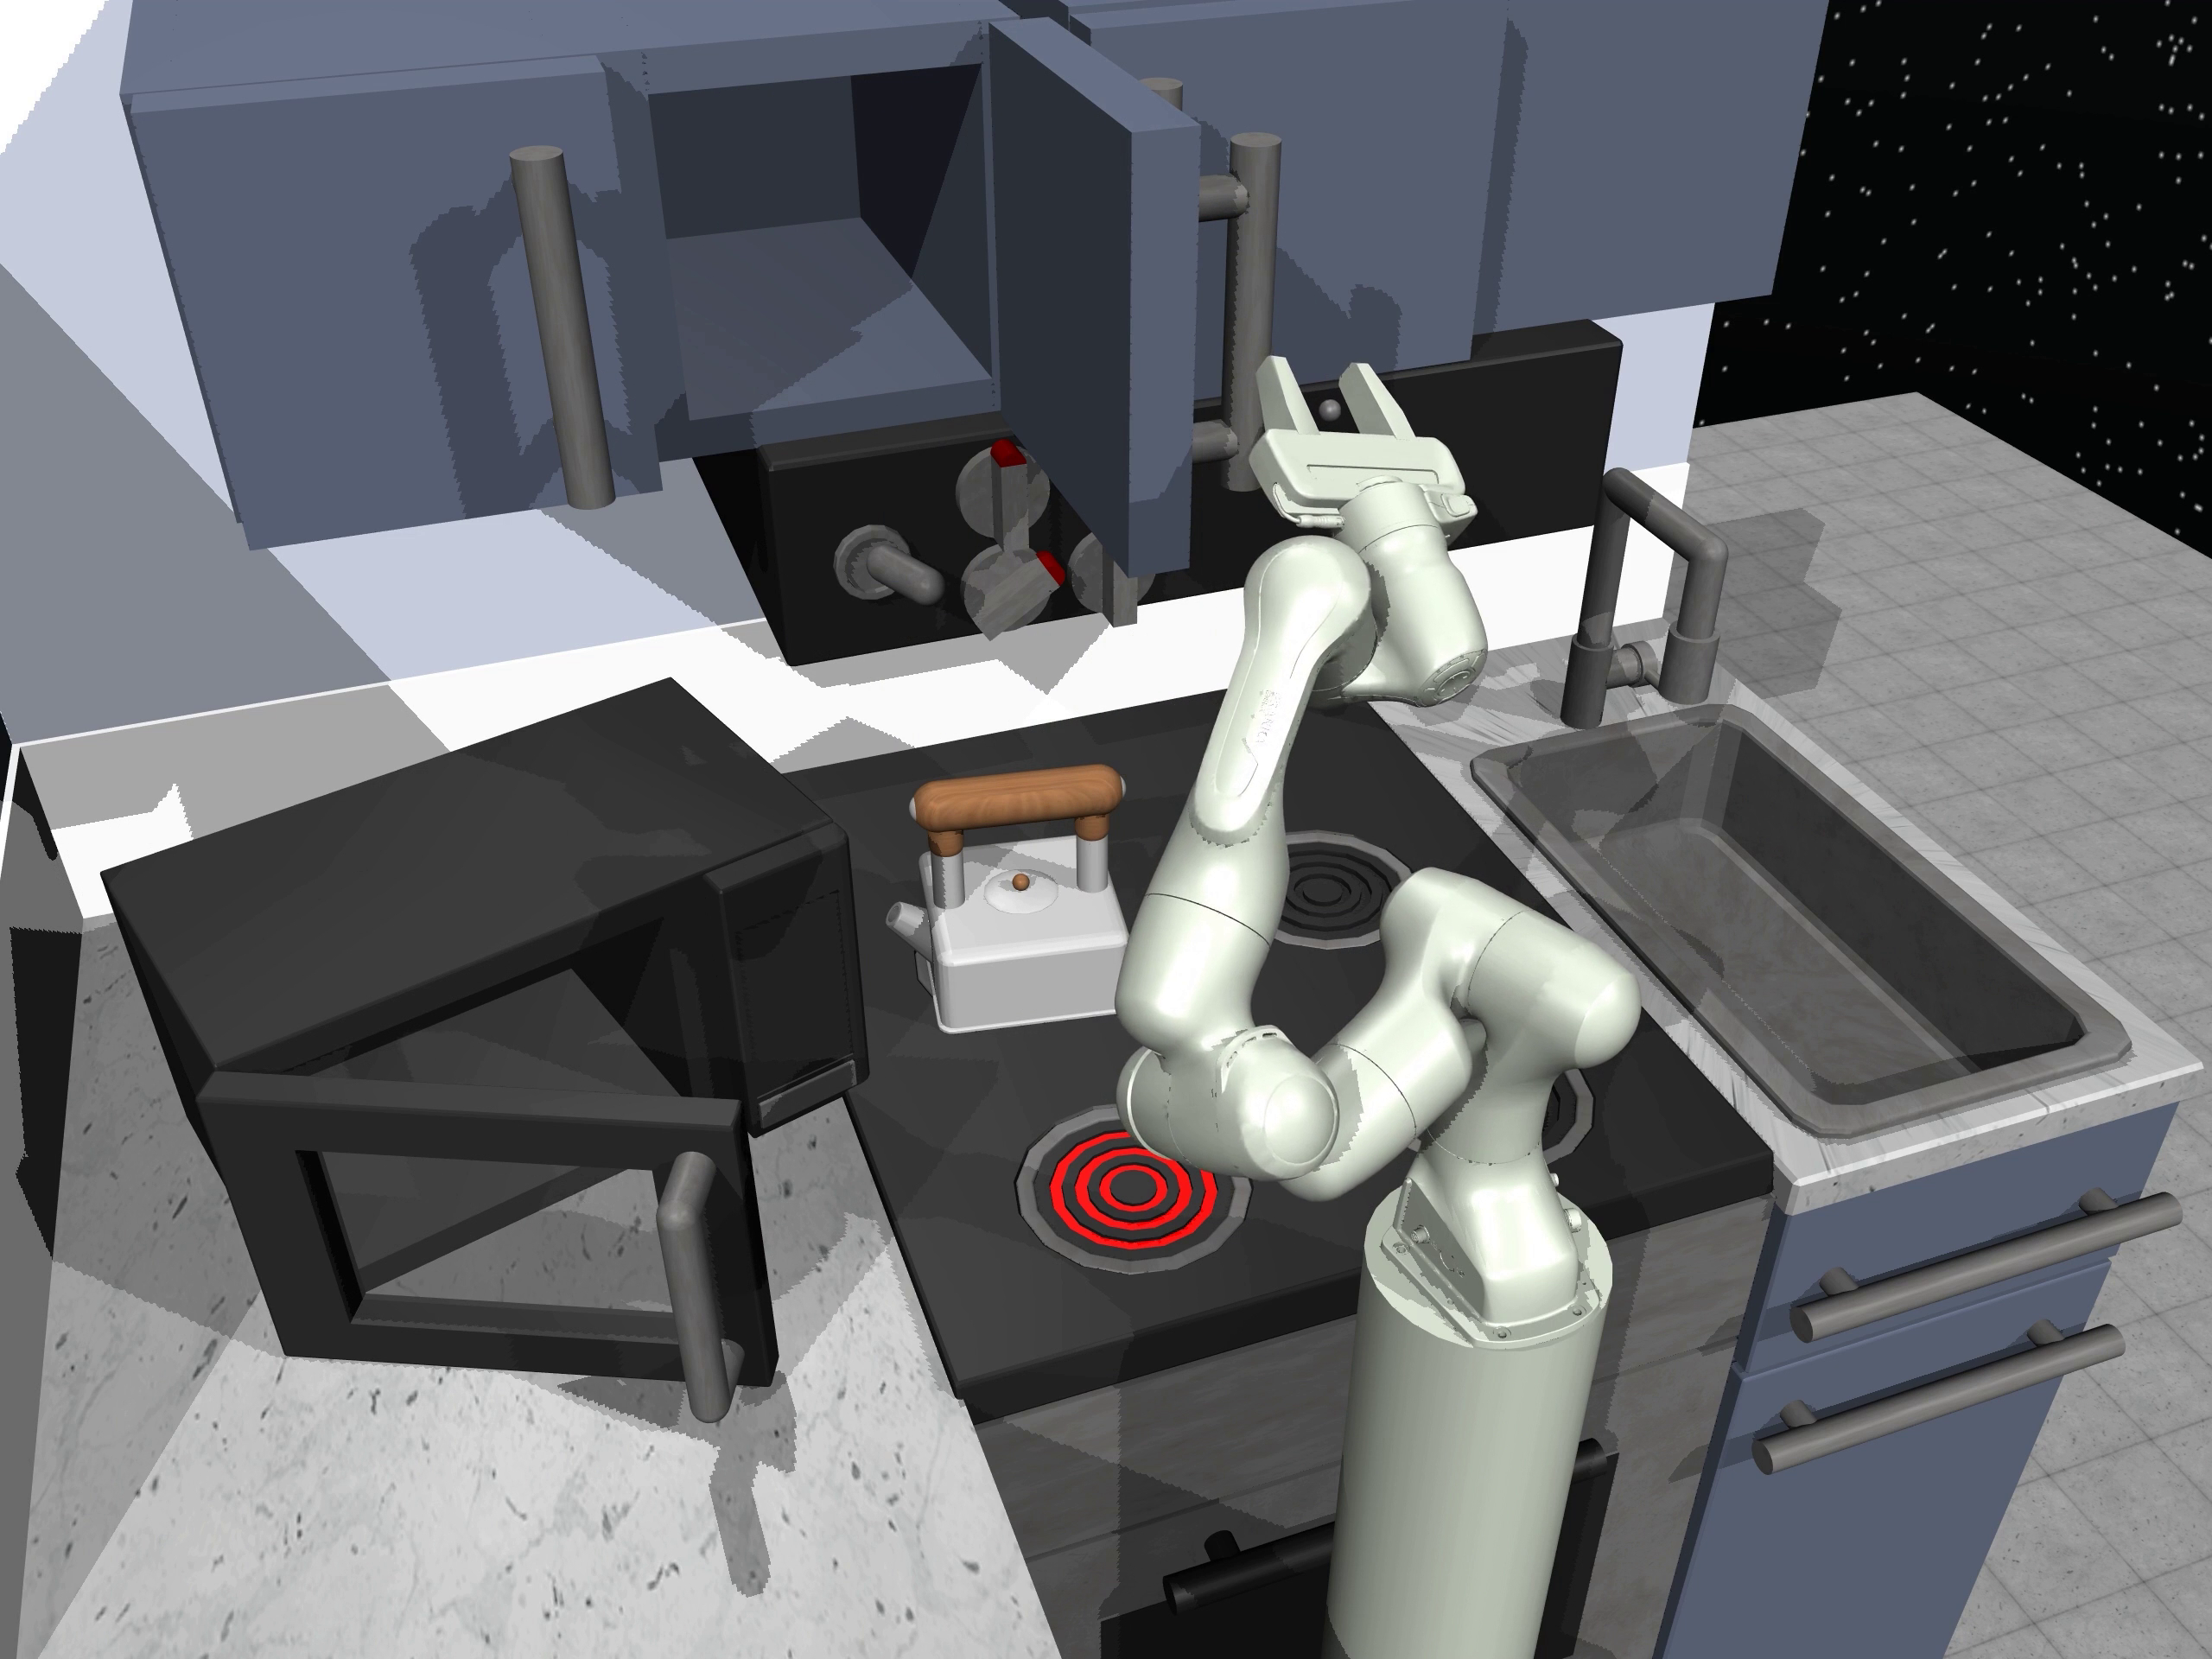

In [13]:
all_frames[3][80]

In [13]:
device = 'cuda'
model, preprocess = clip.load("ViT-B/32", device=device)

In [14]:
batch_size = 24
batch_microwave = math.ceil(len(all_frames[0]) / batch_size)
batch_kettle = math.ceil(len(all_frames[1]) / batch_size)
batch_light = math.ceil(len(all_frames[2]) / batch_size)
batch_slide_cabinet = math.ceil(len(all_frames[3]) / batch_size)
batch_hinge_cabinet = math.ceil(len(all_frames[4]) / batch_size)
batch_bottom_burner= math.ceil(len(all_frames[5]) / batch_size)
batch_top_burner = math.ceil(len(all_frames[6]) / batch_size)


In [19]:
all_taskbatches = []
for i in range(len(all_frames)):
    all_batches = math.ceil(len(all_frames[i]) / batch_size)
    all_taskbatches.append(all_batches)

In [26]:
all_taskbatches

[4, 4, 4, 4, 4, 4, 4]

In [86]:
features = []
all_features = []
for j in range(len(all_taskbatches)):
    image_features = torch.empty([0, 512], dtype=torch.float16).to(device)
    for i in range(all_taskbatches[j]):
        print(f"Batch {i+1}/{all_taskbatches[j]}")
        batch_frame = frames[i*batch_size:(i+1)*batch_size]
        batch_preprocess = torch.stack([preprocess(frame) for frame in batch_frame]).to(device)
        with torch.no_grad():
            batch_features = model.encode_image(batch_preprocess)
            batch_features = batch_features / batch_features.norm(dim=-1, keepdim=True)
        image_features = torch.cat((image_features, batch_features))
    all_features.append(image_features)
    print(f"Features: {image_features.shape}")

Batch 1/4
Batch 2/4
Batch 3/4
Batch 4/4
Features: torch.Size([91, 512])
Batch 1/4
Batch 2/4
Batch 3/4
Batch 4/4
Features: torch.Size([91, 512])
Batch 1/4
Batch 2/4
Batch 3/4
Batch 4/4
Features: torch.Size([91, 512])
Batch 1/4
Batch 2/4
Batch 3/4
Batch 4/4
Features: torch.Size([91, 512])
Batch 1/4
Batch 2/4
Batch 3/4
Batch 4/4
Features: torch.Size([91, 512])
Batch 1/4
Batch 2/4
Batch 3/4
Batch 4/4
Features: torch.Size([91, 512])
Batch 1/4
Batch 2/4
Batch 3/4
Batch 4/4
Features: torch.Size([91, 512])


In [114]:
len(all_features)

7

In [69]:
# image_features = torch.empty([0, 512], dtype=torch.float16).to(device)
# for i in range(batch_kettle):
#     print(f"Batch {i+1}/{batch_kettle}")
#     batch_frame = frames[i*batch_size:(i+1)*batch_size]
#     batch_preprocess = torch.stack([preprocess(frame) for frame in batch_frame]).to(device)
#     with torch.no_grad():
#         batch_features = model.encode_image(batch_preprocess)
#         batch_features = batch_features / batch_features.norm(dim=-1, keepdim=True)
#     image_features = torch.cat((image_features, batch_features))
# print(f"Features: {image_features.shape}")

        

Batch 1/4
Batch 2/4
Batch 3/4
Batch 4/4
Features: torch.Size([91, 512])


In [129]:
def accept_input(prompt, task_id, plot=True, show_frames=False, friend_frames=1):
    with torch.no_grad():
        text_features = model.encode_text(clip.tokenize(prompt).to(device))
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * all_features[task_id] @ text_features.T)
    top_frame, index_frame  = similarity.topk(friend_frames, dim=0)
    if plot:
        fig = px.imshow(similarity.T.cpu().numpy(), height=100, aspect='auto', color_continuous_scale='viridis')
        fig.update_layout(coloraxis_showscale=True)
        fig.update_xaxes(showticklabels=True)
        fig.update_yaxes(showticklabels=True)
        fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
        fig.show()
        plt.plot(similarity.cpu().numpy())
        print()
    
    if show_frames:
        for i in index_frame:
            display(all_frames[task_id][i])
            print(len(all_frames[task_id]))
            seconds = round(i.cpu().numpy()[0] * 1 / frame_all_tasks[task_id])
            display(HTML(f"Found at {str(datetime.timedelta(seconds=seconds))} (<a target=\"_blank\" href=\"{video_all_tasks[task_id]}&t={seconds}\">link</a>)"))

In [ ]:
microwave = 0
kettle = 1
light = 2
slide_cabinet = 3
hinge_cabinet = 4
bottom_burner = 5
top_burner = 6

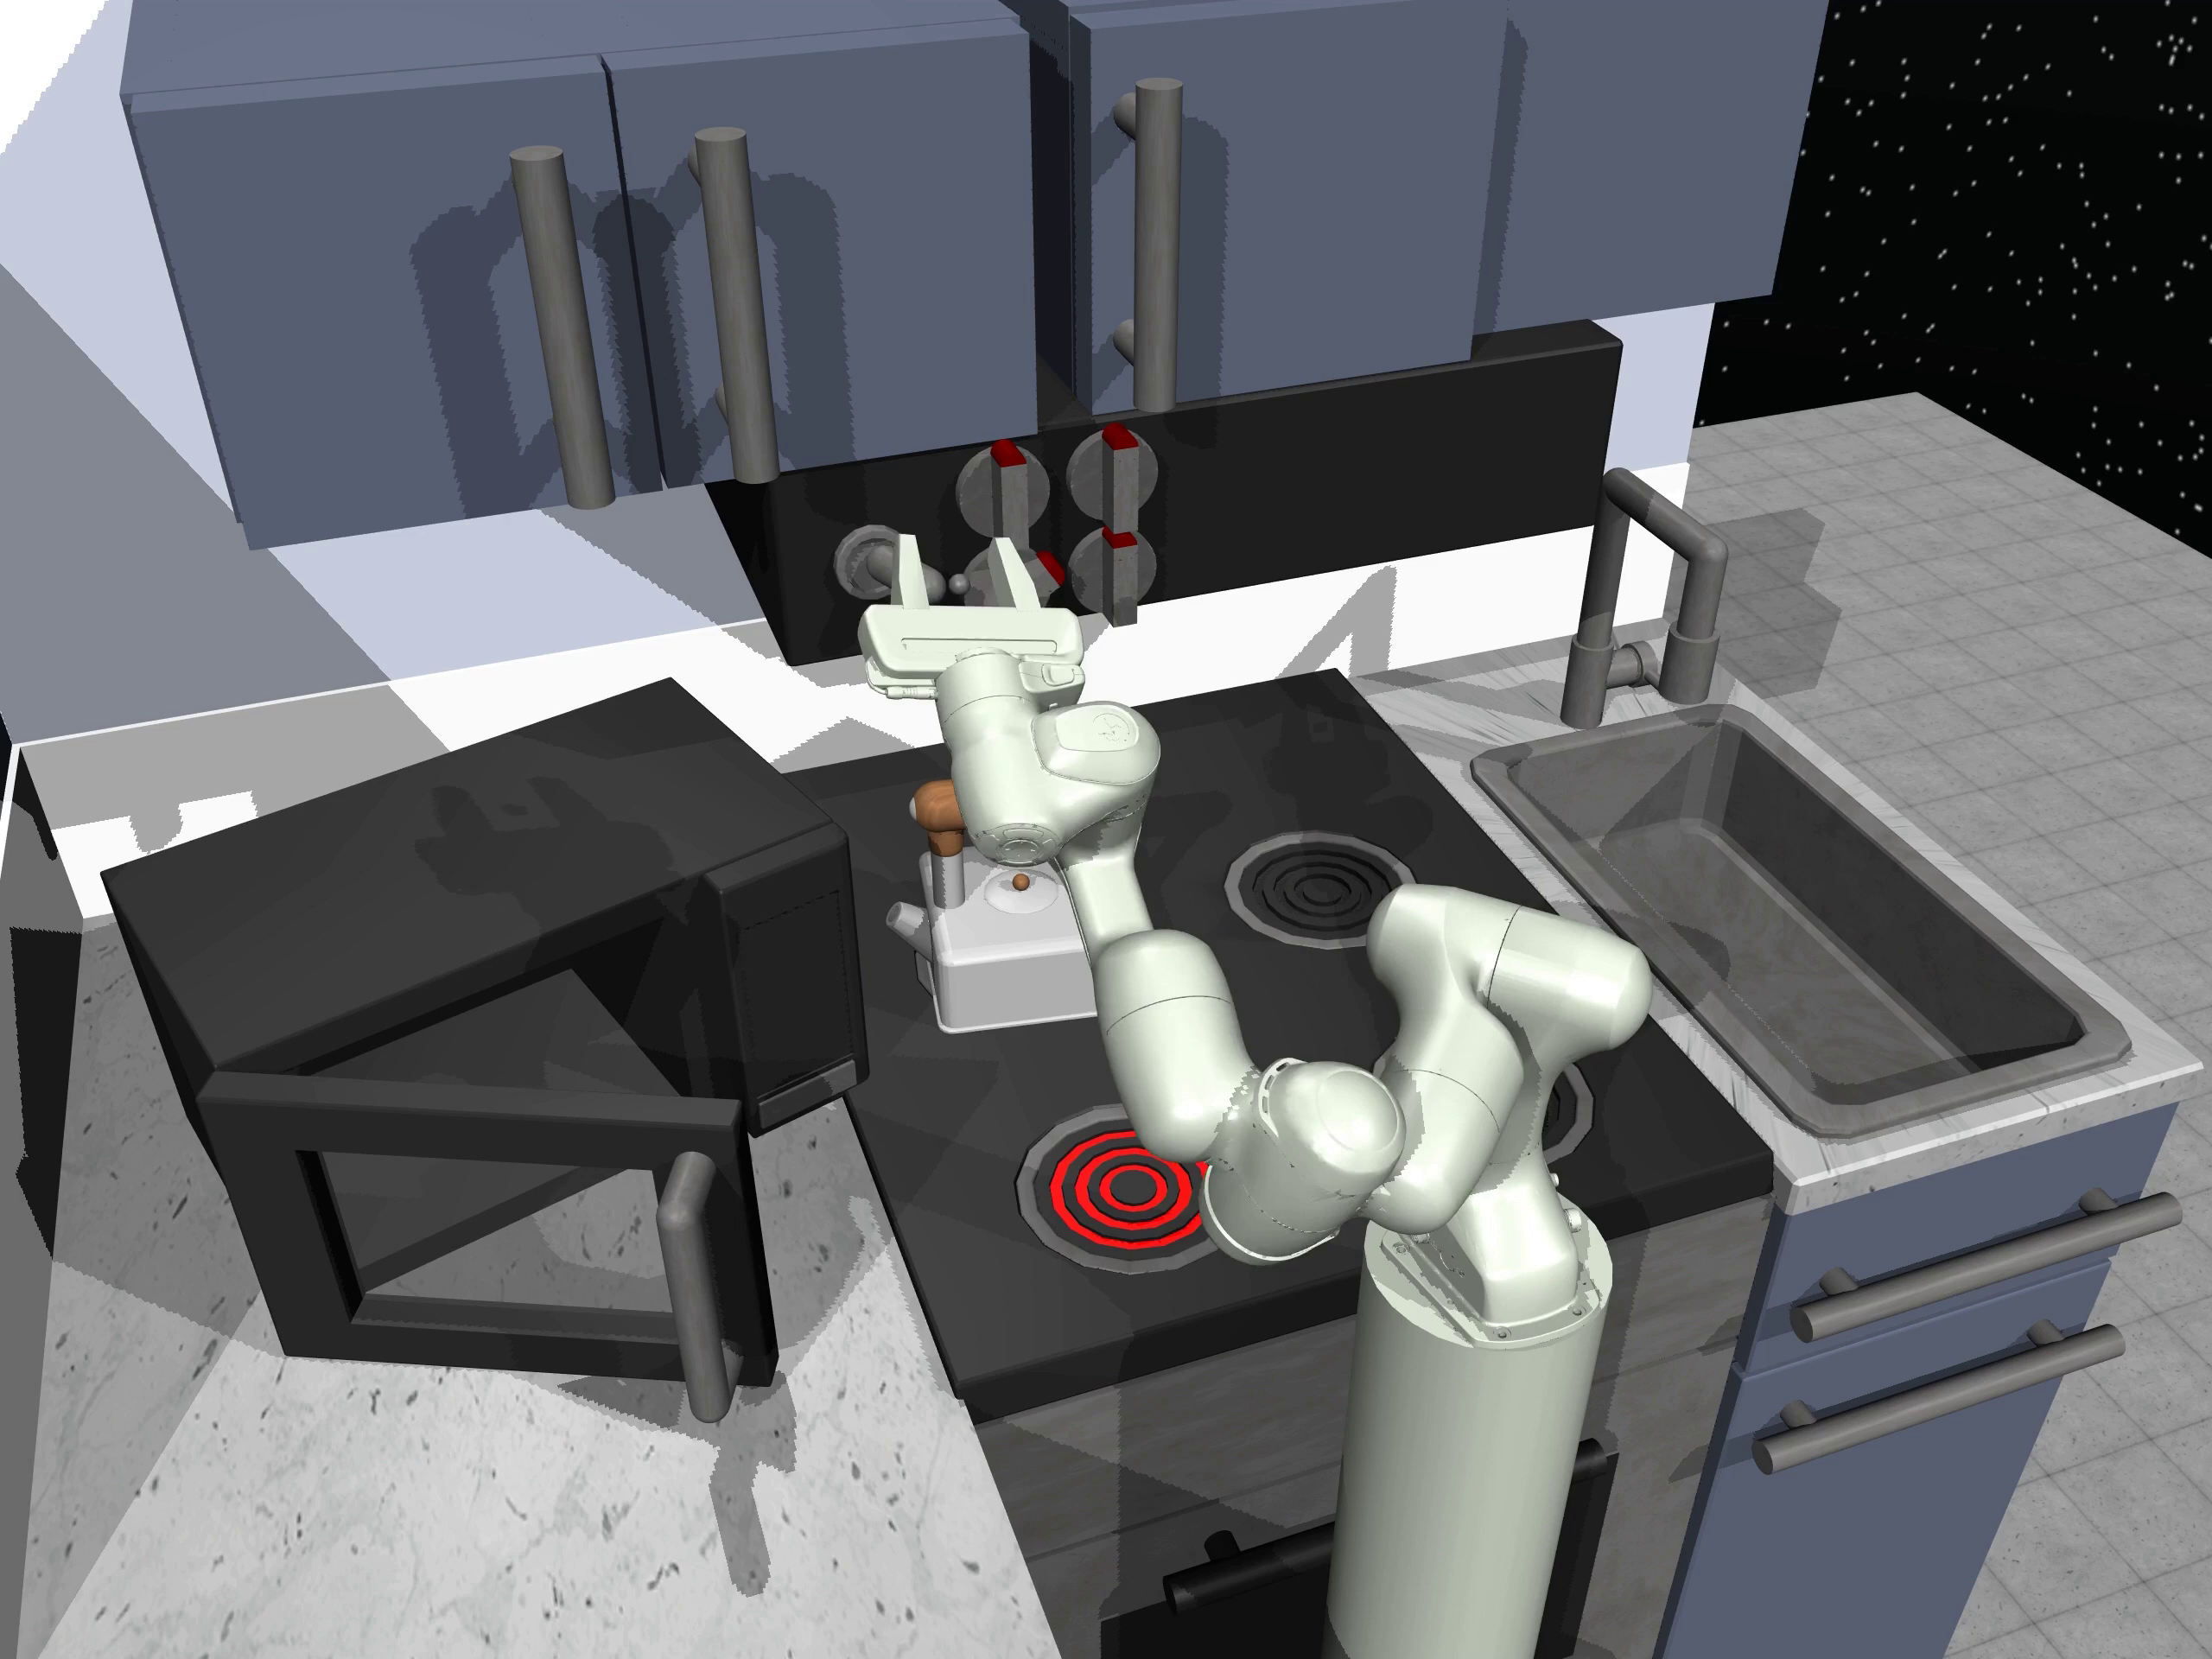

91


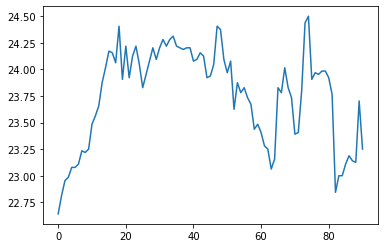

In [130]:
accept_input("push the kettle", task_id=1, plot=True, show_frames=True)

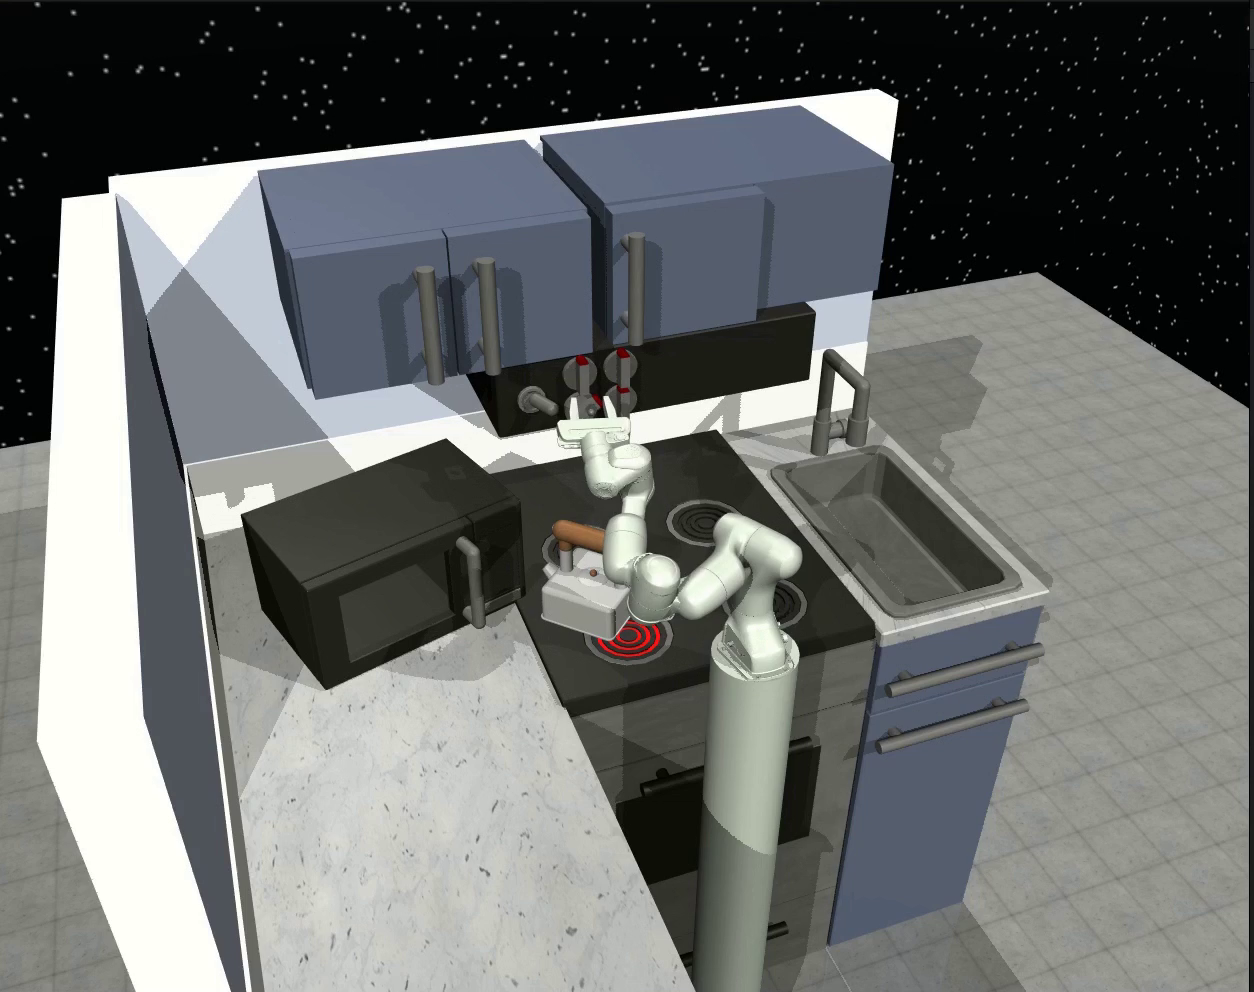

In [145]:
all_frames[2][90]